In [84]:
#imports 

import numpy as np
import os, tempfile
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential

from sklearn.dummy import DummyClassifier

import time
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

import joblib

## Image Load In

In [2]:
!ls

README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch


In [3]:
!cd ..

In [4]:
!ls

README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch


In [5]:
!ls

README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch


In [6]:
# load in the train data

#starting from main project directory

train_normal_dir = "./data/chest_xray/train/NORMAL"
train_pneumonia_dir = "./data/chest_xray/train/PNEUMONIA"

imgs_train_normal = [file for file in os.listdir(train_normal_dir) if file.endswith('.jpeg')]
imgs_train_pneumonia = [file for file in os.listdir(train_pneumonia_dir) if file.endswith('.jpeg')]

In [7]:
test_normal_dir = "./data/chest_xray/test/NORMAL"
test_pneumonia_dir = "./data/chest_xray/test/PNEUMONIA"

imgs_test_normal = [file for file in os.listdir(test_normal_dir) if file.endswith('.jpeg')]
imgs_test_pneumonia = [file for file in os.listdir(test_pneumonia_dir) if file.endswith('.jpeg')]

In [8]:
len(imgs_train_normal)

1341

In [9]:
len(imgs_train_pneumonia)

3875

In [10]:
imgs_train_normal[0]

'IM-0115-0001.jpeg'

In [11]:
imgs_train_pneumonia[0]

'person1000_bacteria_2931.jpeg'

In [12]:
len(imgs_test_normal)

234

In [13]:
len(imgs_test_pneumonia)

390

In [14]:
num_train = len(imgs_train_normal) + len(imgs_train_pneumonia)
num_test = len(imgs_test_normal) + len(imgs_test_pneumonia)
num_train, num_test

(5216, 624)

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [16]:
#rescale images to 64 by 64
#create validation set as 20% of train set

train_folder = "./data/chest_xray/train"
train_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train)

validation_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='validation',
        batch_size= num_train)

test_folder = "./data/chest_xray/test"
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), color_mode='grayscale', 
        class_mode='binary', 
        batch_size= num_test)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(validation_gen)
test_images, test_labels = next(test_gen)

In [19]:
train_images[0]

array([[[0.34509805],
        [0.35686275],
        [0.41960788],
        ...,
        [0.3372549 ],
        [0.29411766],
        [0.3137255 ]],

       [[0.38431376],
        [0.3803922 ],
        [0.38431376],
        ...,
        [0.34901962],
        [0.32941177],
        [0.31764707]],

       [[0.35686275],
        [0.43921572],
        [0.41176474],
        ...,
        [0.44705886],
        [0.5137255 ],
        [0.49803925]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)

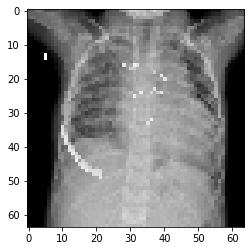

In [53]:
plt.imshow(train_images[0], cmap='gray', vmin=0, vmax=1)

In [20]:
val_images[0]

array([[[0.25882354],
        [0.36078432],
        [0.3803922 ],
        ...,
        [0.5568628 ],
        [0.36862746],
        [0.36078432]],

       [[0.2627451 ],
        [0.34509805],
        [0.3921569 ],
        ...,
        [0.6       ],
        [0.3647059 ],
        [0.34509805]],

       [[0.2392157 ],
        [0.34117648],
        [0.39607847],
        ...,
        [0.38823533],
        [0.3803922 ],
        [0.37254903]],

       ...,

       [[0.02352941],
        [0.04705883],
        [0.02352941],
        ...,
        [0.01568628],
        [0.04313726],
        [0.05490196]],

       [[0.01960784],
        [0.04313726],
        [0.02745098],
        ...,
        [0.01960784],
        [0.04313726],
        [0.0627451 ]],

       [[0.02352941],
        [0.04705883],
        [0.02352941],
        ...,
        [0.02352941],
        [0.04313726],
        [0.04313726]]], dtype=float32)

In [21]:
train_images.shape

(4173, 64, 64, 1)

In [22]:
#(image height, image width, color channels)
train_images[0].shape

(64, 64, 1)

In [23]:
train_labels[0]

1.0

In [24]:
train_labels.shape

(4173,)

In [25]:
val_images.shape

(1043, 64, 64, 1)

In [26]:
val_labels.shape

(1043,)

In [27]:
#reshaping features for dense layers
train_reshape = train_images.reshape(train_images.shape[0], -1)
val_reshape = val_images.reshape(val_images.shape[0], -1)
test_reshape = test_images.reshape(test_images.shape[0], -1)

print(train_reshape.shape)
print(val_reshape.shape)
print(test_reshape.shape)

(4173, 4096)
(1043, 4096)
(624, 4096)


In [28]:
train_labels.shape

(4173,)

In [29]:
val_labels.shape

(1043,)

In [30]:
test_labels.shape

(624,)

In [32]:
#reshaping labels
train_y = np.reshape(train_labels, (4173,1))
val_y = np.reshape(val_labels, (1043,1))
test_y = np.reshape(test_labels, (624,1))

print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(4173, 1)
(1043, 1)
(624, 1)


# Dummy Classifier

In [45]:
dummy_clf = DummyClassifier()
dummy_clf.fit(train_images, train_labels)
dummy_clf.score(val_images, val_labels)

0.7430488974113135

## Baseline Model

In [33]:
baseline_model = models.Sequential()

In [34]:
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(4096,)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                81940     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 82,133
Trainable params: 82,133
Non-trainable params: 0
_________________________________________________________________


In [36]:
baseline_model.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [37]:
train_reshape[0].shape

(4096,)

In [38]:
val_reshape[0].shape

(4096,)

In [39]:
baseline_model.fit(train_reshape, 
                   train_y, 
                   epochs=50, 
                   batch_size=32, 
                   validation_data=(val_reshape, val_y))

Epoch 1/50
131/131 [==============================] - 4s 16ms/step - loss: 0.5611 - accuracy: 0.7388 - val_loss: 0.4850 - val_accuracy: 0.7430
Epoch 2/50
131/131 [==============================] - 1s 5ms/step - loss: 0.3848 - accuracy: 0.8289 - val_loss: 0.3847 - val_accuracy: 0.8015
Epoch 3/50
131/131 [==============================] - 1s 5ms/step - loss: 0.2970 - accuracy: 0.8740 - val_loss: 0.5450 - val_accuracy: 0.7411
Epoch 4/50
131/131 [==============================] - 1s 4ms/step - loss: 0.2568 - accuracy: 0.8922 - val_loss: 0.2174 - val_accuracy: 0.9070
Epoch 5/50
131/131 [==============================] - 1s 4ms/step - loss: 0.2270 - accuracy: 0.9092 - val_loss: 0.4529 - val_accuracy: 0.8082
Epoch 6/50
131/131 [==============================] - 1s 4ms/step - loss: 0.1833 - accuracy: 0.9293 - val_loss: 0.3017 - val_accuracy: 0.8744
Epoch 7/50
131/131 [==============================] - 1s 4ms/step - loss: 0.1941 - accuracy: 0.9195 - val_loss: 0.1840 - val_accuracy: 0.9252
Epoch

In [40]:
results_train = baseline_model.evaluate(train_reshape, train_y)
results_train

131/131 [==============================] - 1s 7ms/step - loss: 0.2145 - accuracy: 0.9183


[0.21445898711681366, 0.9182842373847961]

In [42]:
results_val = baseline_model.evaluate(val_reshape, val_y)
results_val

33/33 [==============================] - 0s 5ms/step - loss: 0.2825 - accuracy: 0.9003


[0.2825089991092682, 0.9002876281738281]

## Convolutional Neural Networks - CNNs

In [66]:
#setting up a simple convolutional model
simple_cnn = models.Sequential()

simple_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))
simple_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
simple_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
#single dense layer
simple_cnn.add(layers.Flatten())
simple_cnn.add(layers.Dense(64, activation='relu'))
#output layer
simple_cnn.add(layers.Dense(1, activation='sigmoid'))

In [67]:
simple_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3444800   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 3,482,433
Trainable params: 3,482,433
Non-trainable params: 0
____________________________________________

In [77]:
simple_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [78]:
simple_cnn.fit(train_images, train_labels, epochs=10, batch_size=400)

Epoch 1/10
11/11 [==============================] - 9s 594ms/step - loss: 0.4193 - accuracy: 0.7992 - precision: 0.7888
Epoch 2/10
11/11 [==============================] - 7s 602ms/step - loss: 0.4524 - accuracy: 0.8243 - precision: 0.8270
Epoch 3/10
11/11 [==============================] - 7s 598ms/step - loss: 0.3948 - accuracy: 0.8351 - precision: 0.8324
Epoch 4/10
11/11 [==============================] - 7s 643ms/step - loss: 0.4293 - accuracy: 0.8112 - precision: 0.8284
Epoch 5/10
11/11 [==============================] - 7s 602ms/step - loss: 0.3908 - accuracy: 0.8430 - precision: 0.8557
Epoch 6/10
11/11 [==============================] - 6s 587ms/step - loss: 0.4066 - accuracy: 0.8203 - precision: 0.8422
Epoch 7/10
11/11 [==============================] - 7s 622ms/step - loss: 0.3139 - accuracy: 0.8890 - precision: 0.8861
Epoch 8/10
11/11 [==============================] - 7s 612ms/step - loss: 0.3312 - accuracy: 0.8658 - precision: 0.8812
Epoch 9/10
11/11 [======================

In [79]:
simple_cnn_train = simple_cnn.evaluate(train_images, train_labels)
simple_cnn_train

131/131 [==============================] - 4s 22ms/step - loss: 0.2789 - accuracy: 0.9154 - precision: 0.9467


[0.2788931131362915, 0.9154085516929626, 0.9466666579246521]

In [80]:
simple_cnn_val = simple_cnn.evaluate(val_images, val_labels)
simple_cnn_val

33/33 [==============================] - 1s 25ms/step - loss: 0.3074 - accuracy: 0.8859 - precision: 0.9216


[0.30743056535720825, 0.8859060406684875, 0.9215938448905945]

Our first CNN had some overfitting (91% accuracy on the train set and 89% accuracy on the validation set). Precision was also better for the train set (94%) than the validation set (92%).

In [97]:
type(simple_cnn_val)

list

In [102]:
#helper function to store metrics in a dictionary format for easy recall
def metrics_to_dict(model_name, metrics, metrics_dict):
    '''
    Returns a dictionary with model name as key and dictionaries of metrics
    as values
    Nested dictionary has metric names as keys and the scores as values
    
    Takes the following arguments:
    model_name: String of model name
    metrics: list of metric scores from model.evaluate(), must match metric_names
    metrics_dict: dictionary to be added to
    '''
    metrics_dict[model_name]={}
    metric_names = ['loss', 'accuracy', 'precision']
    for i,metric in enumerate(metric_names):
        metrics_dict[model_name][metric] = metrics[i]
    return metrics_dict

In [103]:
metrics_dict = {}
metrics_to_dict('simple_cnn', simple_cnn_val, metrics_dict)
metrics_dict

{'simple_cnn': {'loss': 0.30743056535720825,
  'accuracy': 0.8859060406684875,
  'precision': 0.9215938448905945}}

In [85]:
!ls

README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch
simple_cnn.pkl


In [94]:
#!mkdir saved_models

In [95]:
!ls

-p
README.md
Yuhkai_notebook_scratch.ipynb
data
data.zip
notebooks_scratch
saved_models
simple_cnn.pkl


In [96]:
#saving off the model as pkl file
#simple_cnn.save('saved_models/simple_cnn')

INFO:tensorflow:Assets written to: saved_models/simple_cnn\assets


## Second CNN Model

In [108]:
#second convolutional neural network
second_cnn = models.Sequential()

#adding more convolutional and pooling layers
second_cnn.add(layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', 
          input_shape=(64, 64, 1)))
second_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
second_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
second_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
second_cnn.add(layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu'))

#two dense layers
second_cnn.add(layers.Flatten())
second_cnn.add(layers.Dense(64, activation='relu'))
second_cnn.add(layers.Dense(64, activation='relu'))
#output layer
second_cnn.add(layers.Dense(1, activation='sigmoid'))

In [109]:
second_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 61, 61, 64)        1088      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        65600     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

In [112]:
second_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [113]:
second_cnn.fit(train_images, train_labels, epochs=10, batch_size=400)

Epoch 1/10
11/11 [==============================] - 5s 369ms/step - loss: 0.6819 - accuracy: 0.6463 - precision_2: 0.7470
Epoch 2/10
11/11 [==============================] - 4s 358ms/step - loss: 0.6455 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 3/10
11/11 [==============================] - 4s 362ms/step - loss: 0.6090 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 4/10
11/11 [==============================] - 4s 358ms/step - loss: 0.5814 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 5/10
11/11 [==============================] - 4s 360ms/step - loss: 0.5713 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 6/10
11/11 [==============================] - 4s 360ms/step - loss: 0.5689 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 7/10
11/11 [==============================] - 4s 363ms/step - loss: 0.5679 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 8/10
11/11 [==============================] - 4s 364ms/step - loss: 0.5669 - accuracy: 0.7429 - precision_2: 0.7429
Epoch 9/10
11/11 [======

In [ ]:
#ran ths second model multiple times, usually got stuck around 0.7429 accuracy

In [118]:
second_cnn.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [119]:
second_cnn.fit(train_images, train_labels, epochs=10, batch_size=400)

Epoch 1/10
11/11 [==============================] - 5s 361ms/step - loss: 0.4866 - accuracy: 0.7429 - precision_5: 0.7429
Epoch 2/10
11/11 [==============================] - 4s 362ms/step - loss: 0.4696 - accuracy: 0.7431 - precision_5: 0.7430
Epoch 3/10
11/11 [==============================] - 4s 357ms/step - loss: 0.4597 - accuracy: 0.7525 - precision_5: 0.7502
Epoch 4/10
11/11 [==============================] - 4s 328ms/step - loss: 0.4367 - accuracy: 0.7695 - precision_5: 0.7641
Epoch 5/10
11/11 [==============================] - 4s 327ms/step - loss: 0.4178 - accuracy: 0.8009 - precision_5: 0.7916
Epoch 6/10
11/11 [==============================] - 4s 326ms/step - loss: 0.5014 - accuracy: 0.7985 - precision_5: 0.8149
Epoch 7/10
11/11 [==============================] - 4s 341ms/step - loss: 0.4388 - accuracy: 0.8090 - precision_5: 0.8135
Epoch 8/10
11/11 [==============================] - 4s 334ms/step - loss: 0.3947 - accuracy: 0.8284 - precision_5: 0.8229
Epoch 9/10
11/11 [======

In [123]:
second_cnn_train = second_cnn.evaluate(train_images, train_labels)
second_cnn_train

131/131 [==============================] - 2s 15ms/step - loss: 0.4306 - accuracy: 0.8497 - precision_5: 0.9647


[0.4305930435657501, 0.8497483730316162, 0.9646749496459961]

In [122]:
second_cnn_val = second_cnn.evaluate(val_images, val_labels)
second_cnn_val

33/33 [==============================] - 1s 16ms/step - loss: 0.4541 - accuracy: 0.8150 - precision_5: 0.9491


[0.45411476492881775, 0.8149568438529968, 0.9490740895271301]

This second model has less accuracy (still overfit) but higher precision.

In [125]:
print(len(train_images))
print(len(val_images))

4173
1043
